# beblid-opencv-demo
## How to improve a 14% your image matching with only one line of code? BEBLID is the key!

Install OpenCV version 4.5.1 or higher

In [1]:
!pip install "opencv-contrib-python>=4.5.1"
import cv2 as cv
# Uncomment to see the OpenCV build information
# print(cv.getBuildInformation())
print(f"OpenCV Version: {cv.__version__}")

OpenCV Version: 4.5.1


In [2]:
# If you are running the notebook on Google Colab uncomment this to download the files
#!wget https://raw.githubusercontent.com/opencv/opencv/4.5.1/samples/data/graf1.png
#!wget https://raw.githubusercontent.com/opencv/opencv/4.5.1/samples/data/graf3.png
#!wget https://raw.githubusercontent.com/opencv/opencv/4.5.1/samples/data/H1to3p.xml

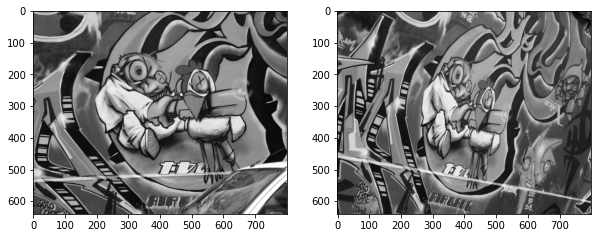

In [3]:
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt

img1 = cv.imread("graf1.png", cv.IMREAD_GRAYSCALE)
img2 = cv.imread("graf3.png", cv.IMREAD_GRAYSCALE)


if img1 is None or img2 is None:
    print('Could not open or find the images!')
    exit(0)
    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(img1, cmap='gray')
ax2.imshow(img2, cmap='gray')


In [4]:
# Load homography (geometric transformation between image)
fs = cv.FileStorage("H1to3p.xml", cv.FILE_STORAGE_READ)
homography = fs.getFirstTopLevelNode().mat()
print(f"Homography from img1 to img2:\n{homography}")

Homography from img1 to img2:
[[ 7.6285898e-01 -2.9922929e-01  2.2567123e+02]
 [ 3.3443473e-01  1.0143901e+00 -7.6999973e+01]
 [ 3.4663091e-04 -1.4364524e-05  1.0000000e+00]]


Now lets create the local image feature detector. We are going to use ORB, which is a fast corner detector and we are going to require it to detect a maximum of 10000 corners in the image.

In [5]:
detector = cv.ORB_create(10000)
kpts1 = detector.detect(img1, None)
kpts2 = detector.detect(img2, None)

# descriptor = cv.ORB_create()
descriptor = cv.xfeatures2d.BEBLID_create(0.75)
kpts1, desc1 = descriptor.compute(img1, kpts1)
kpts2, desc2 = descriptor.compute(img2, kpts2)

Now we have to match the descriptors from both images. We're going to do it by using Brute Force matching and Hamming distance, i.e., counting the number of bits that are different between each pair of descriptors.

We also use a trick called the ratio-test, that ensures, not only are the descriptors 1 and 2 similar to each other, but also that there is no other descriptor as close to 1 as 2 is.

In [6]:
matcher = cv.DescriptorMatcher_create(cv.DescriptorMatcher_BRUTEFORCE_HAMMING)
nn_matches = matcher.knnMatch(desc1, desc2, 2)
matched1 = []
matched2 = []
nn_match_ratio = 0.8  # Nearest neighbor matching ratio
for m, n in nn_matches:
    if m.distance < nn_match_ratio * n.distance:
        matched1.append(kpts1[m.queryIdx])
        matched2.append(kpts2[m.trainIdx])

Since we know the correct geometric transformation lets check how many of the matches are correct (inliners). 

In [7]:
inliers1 = []
inliers2 = []
good_matches = []
inlier_threshold = 2.5  # Distance threshold to identify inliers with homography check
for i, m in enumerate(matched1):
    # Create the homogeneous point
    col = np.ones((3, 1), dtype=np.float64)
    col[0:2, 0] = m.pt
    # Project from image 1 to image 2
    col = np.dot(homography, col)
    col /= col[2, 0]
    # Calculate euclidean distance
    dist = sqrt(pow(col[0, 0] - matched2[i].pt[0], 2) + \
                pow(col[1, 0] - matched2[i].pt[1], 2))
    if dist < inlier_threshold:
        good_matches.append(cv.DMatch(len(inliers1), len(inliers2), 0))
        inliers1.append(matched1[i])
        inliers2.append(matched2[i])

Now lets visualize the correctly matched points

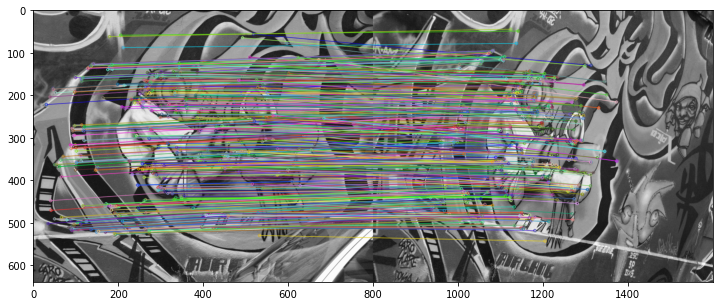

In [8]:
res = np.empty((max(img1.shape[0], img2.shape[0]), img1.shape[1] + img2.shape[1], 3), dtype=np.uint8)
cv.drawMatches(img1, inliers1, img2, inliers2, good_matches, res)
plt.figure(figsize=(15, 5))
plt.imshow(res)

The more inliers we have, the more robust our matching algorithm will be. So lets print some quantitative measurements:

In [9]:
inlier_ratio = len(inliers1) / float(len(matched1))
print('Matching Results')
print('*******************************')
print('# Keypoints 1:                        \t', len(kpts1))
print('# Keypoints 2:                        \t', len(kpts2))
print('# Matches:                            \t', len(matched1))
print('# Inliers:                            \t', len(inliers1))
print('# Inliers Ratio:                      \t', inlier_ratio)

Matching Results
*******************************
# Keypoints 1:                        	 9105
# Keypoints 2:                        	 9927
# Matches:                            	 660
# Inliers:                            	 512
# Inliers Ratio:                      	 0.7757575757575758


### Conclusion
We can observe the the percentage of matches obtained with **BEBLID is 77.57%**, much higher that the **62.68% obtained by the ORB** descriptor.

Futhermore, the good BEBLID implemetation makes it as fast as ORB. Don't think it twice, use BEBLID!